# Global Imports

In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict
from collections import Counter
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence

random.seed(42)

# Local Imports

In [2]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.word_dataset import WordImageDataset
from models.allcnn2d import AllCNN2D
from models.allcnn2d_rnn import CNNRNNModel

# Globals

In [3]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "KrudRNN_v2"
LOAD_CHECKPOINT: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\src\cnn_rnn\20250409_235550__cnn_rnn_model__Epoch1_tLoss0.01280_tAcc0.97172_vLoss0.00152_vAcc0.99595.pt"

# Define Paths
Workspace

In [4]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "lambda"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [5]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-f]+)[-]+([0-9]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)

len(image_paths)

1286

# Helper Functions

In [6]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [7]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    epoch: int,
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels From File Names

In [8]:


labeled_image_paths: list[tuple[str, str]] = []

class_counts: dict[str, int] = defaultdict(lambda: 0)

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)[1:]
    
    char: str = chr(int(u_hexvalue, base=16))
    
    
    class_counts[char] += 1
    
    
    labeled_image_paths.append((char, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))

len(labels), len(image_paths)

(1286, 1286)

In [9]:
Counter(labels)

Counter({'+': 54,
         'a': 54,
         '1': 54,
         '.': 49,
         'λ': 49,
         '(': 48,
         ')': 48,
         ':': 29,
         '<': 24,
         '-': 23,
         '÷': 23,
         '×': 22,
         ']': 22,
         '>': 22,
         '=': 22,
         '[': 22,
         '}': 21,
         '8': 20,
         'c': 20,
         'p': 20,
         's': 20,
         '5': 20,
         'v': 20,
         'f': 20,
         '6': 20,
         'i': 20,
         'o': 20,
         'y': 20,
         '4': 20,
         'z': 20,
         '2': 20,
         'x': 20,
         'm': 20,
         'e': 20,
         'w': 20,
         't': 20,
         'd': 20,
         'b': 20,
         'g': 20,
         '{': 20,
         'j': 20,
         '7': 20,
         'k': 20,
         'q': 20,
         '0': 20,
         'h': 20,
         'l': 20,
         'u': 20,
         '3': 20,
         'n': 20,
         '9': 20,
         'r': 20})

# Balance Classes Using Oversample/Undersample

In [10]:
sorted_counts: list[tuple[str, int]] = sorted(
    class_counts.items(), 
    key=lambda x: x[0]
)

counts: list[int] = [pair[1] for pair in sorted_counts]

max_count: int = max(counts)
min_count: int = min(counts)

to_add_counts: dict[str, int] = {
    uid: max_count - count 
    for uid, count in 
    sorted_counts
}

to_undersample_counts: dict[str, int] = {
    uid: min_count
    for uid, count in 
    sorted_counts
}

total_items = sum(x[1] for x in sorted_counts)


In [11]:
min_count, max_count, total_items

(20, 54, 1286)

In [12]:
#print(*to_add_counts.items())
#print(sorted([(chr(int(pair[0][1:], 16)), pair[1]) for pair in to_remove_counts.items()], key=lambda x: x[1]))

# Oversample

In [13]:
#to_add_labels: list[str] = []
#to_add_file_paths: list[str] = []
#
#while True in [to_add_count>0 for to_add_count in to_add_counts.values()]:  
#    for label, image_path in zip(labels, image_paths):
#        remaining: int = to_add_counts[label]
#        
#        if remaining > 0:
#            to_add_labels.append(label)
#            to_add_file_paths.append(image_path)
#            to_add_counts[label] -= 1

# Undersample

In [14]:
to_keep_labels: list[str] = []
to_keep_file_paths: list[str] = []

while True in [to_add_count>0 for to_add_count in to_undersample_counts.values()]:  
    for label, image_path in zip(labels, image_paths):
        remaining: int = to_undersample_counts[label]
        
        if remaining > 0:
            to_keep_labels.append(label)
            to_keep_file_paths.append(image_path)
            to_undersample_counts[label] -= 1

In [15]:
to_keep_labels

['8',
 'c',
 'p',
 's',
 's',
 '5',
 'v',
 '×',
 'f',
 '6',
 '8',
 'i',
 'v',
 '+',
 'o',
 'y',
 '4',
 '(',
 'z',
 '2',
 'x',
 'm',
 '+',
 '-',
 'e',
 's',
 'w',
 '×',
 't',
 'd',
 ']',
 's',
 'o',
 '.',
 'b',
 'o',
 'g',
 'o',
 ')',
 'd',
 'c',
 'λ',
 'a',
 '{',
 '<',
 'y',
 'λ',
 'a',
 '+',
 'j',
 'v',
 '2',
 '.',
 'd',
 '>',
 '6',
 't',
 't',
 'c',
 'm',
 'i',
 'p',
 'm',
 ')',
 '(',
 'g',
 '(',
 'b',
 '7',
 'k',
 '÷',
 'p',
 'e',
 '.',
 ')',
 'p',
 '>',
 '}',
 'e',
 '÷',
 'm',
 'w',
 '(',
 ')',
 '1',
 'q',
 '0',
 'q',
 'x',
 'g',
 'i',
 'e',
 'h',
 't',
 'i',
 'l',
 'b',
 'y',
 'λ',
 'i',
 'x',
 '0',
 '+',
 ':',
 '.',
 ')',
 'x',
 '(',
 '(',
 'l',
 'd',
 '1',
 'h',
 'j',
 'u',
 '3',
 '1',
 ')',
 'n',
 '1',
 '.',
 'p',
 'h',
 'x',
 'λ',
 'q',
 '>',
 '.',
 'a',
 ':',
 'v',
 'a',
 'g',
 '0',
 's',
 ')',
 '9',
 ']',
 'λ',
 ':',
 'k',
 '=',
 'c',
 '>',
 '-',
 '2',
 ']',
 'p',
 'm',
 'c',
 '>',
 'y',
 '0',
 'w',
 '1',
 'u',
 'p',
 'm',
 '+',
 'b',
 '3',
 'b',
 '{',
 '(',
 'k',
 '+',
 'r'

In [16]:

Counter(to_keep_labels), sorted(list(set(to_keep_labels)))

(Counter({'8': 20,
          'c': 20,
          'p': 20,
          's': 20,
          '5': 20,
          'v': 20,
          '×': 20,
          'f': 20,
          '6': 20,
          'i': 20,
          '+': 20,
          'o': 20,
          'y': 20,
          '4': 20,
          '(': 20,
          'z': 20,
          '2': 20,
          'x': 20,
          'm': 20,
          '-': 20,
          'e': 20,
          'w': 20,
          't': 20,
          'd': 20,
          ']': 20,
          '.': 20,
          'b': 20,
          'g': 20,
          ')': 20,
          'λ': 20,
          'a': 20,
          '{': 20,
          '<': 20,
          'j': 20,
          '>': 20,
          '7': 20,
          'k': 20,
          '÷': 20,
          '}': 20,
          '1': 20,
          'q': 20,
          '0': 20,
          'h': 20,
          'l': 20,
          ':': 20,
          'u': 20,
          '3': 20,
          'n': 20,
          '9': 20,
          '=': 20,
          'r': 20,
          '[': 20}),
 ['(',
  '

# Load Dataset

In [17]:
image_paths = to_keep_file_paths
labels = to_keep_labels
len(image_paths), len(labels)

(1040, 1040)

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

def stratified_split(file_paths, labels, test_size=0.15, val_size=0.15, min_samples=1, random_state=42):
    """
    Stratified split with minimum samples per class in all splits
    
    Args:
        file_paths: List of lists of paths - [[class1_paths], [class2_paths], ...]
        labels: List of class labels corresponding to file_paths
        test_size: Proportion for test split
        val_size: Proportion for validation split (relative to remaining after test)
        min_samples: Minimum samples per class in each split (default=1)
    """
    # Flatten structure and create label array
    
    # Convert to numpy arrays
    X = np.array(file_paths)
    y = np.array(labels)
    unique_classes = np.unique(y)
    
    # First split: test with min samples per class
    test_indices = []
    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0]
        n_test = max(min_samples, int(test_size * len(cls_indices)))
        test_indices.extend(np.random.choice(cls_indices, n_test, replace=False))
    
    # Remaining indices for train/val
    remaining_mask = ~np.isin(np.arange(len(X)), test_indices)
    X_remaining, y_remaining = X[remaining_mask], y[remaining_mask]
    
    # Second split: validation from remaining
    val_indices = []
    for cls in unique_classes:
        cls_indices = np.where(y_remaining == cls)[0]
        n_val = max(min_samples, int(val_size * len(cls_indices)))
        val_indices.extend(np.random.choice(cls_indices, n_val, replace=False))
    
    # Final indices
    train_mask = ~np.isin(np.arange(len(X_remaining)), val_indices)
    return (
        X_remaining[train_mask].tolist(), y_remaining[train_mask].tolist(),  # Train
        X_remaining[val_indices].tolist(), y_remaining[val_indices].tolist(),  # Val
        X[test_indices].tolist(), y[test_indices].tolist()  # Test
    )



In [19]:



train_x, train_y, val_x, val_y, test_x, test_y = stratified_split(image_paths, labels)

print(f"Train ({len(train_x)}): {train_x} {train_y}")
print(f"Val   ({len(val_x)}): {val_x} {val_y}")
print(f"Test  ({len(test_x)}): {test_x} {test_y}")

Train (780): ['c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u38-1737059278788.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u63-1737059641321.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u73-1737059958930.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u73-1737713959686.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u35-1737060039410.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u76-1737715357236.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\data\\lambda\\u66-1737714100430.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_rnn\\..\\..\\

In [20]:
all_label_classes = [
    '(',
    ')',
    '+',
    '-',
    '.',
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9',
    ':',
    '<',
    '=',
    '>',
    '[',
    ']',
    'a',
    'b',
    'c',
    'd',
    'e',
    'f',
    'g',
    'h',
    'i',
    'j',
    'k',
    'l',
    'm',
    'n',
    'o',
    'p',
    'q',
    'r',
    's',
    't',
    'u',
    'v',
    'w',
    'x',
    'y',
    'z',
    '{',
    '}',
    '×',
    '÷',
    'λ'
]


# Get valid words

In [21]:
import pandas as pd
valid_words = pd.read_csv("metadata-lambda.csv")["line"].to_list()

num_words = len(valid_words)

train_words = valid_words[:int(num_words*0.8)]
val_words = valid_words[int(num_words*0.8):]

MAX_LEN: int = 10

train_words = [word[:MAX_LEN] if len(word) >= 10 else word for word in train_words]
val_words = [word[:MAX_LEN] if len(word) >= 10 else word for word in val_words]

# Load Dataloaders

In [22]:
len(all_label_classes)

52

In [23]:
all_label_classes

['(',
 ')',
 '+',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '<',
 '=',
 '>',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '}',
 '×',
 '÷',
 'λ']

In [24]:

train_char_dataset: WordImageDataset = WordImageDataset(
    words=train_words,
    file_paths=train_x, #list(image_paths[:split_index]) + to_add_file_paths,
    labels=train_y, #list(labels[:split_index]) + to_add_labels,
    all_label_classes=all_label_classes,
    rotation_limit=0.05,
    translation_limit=0.2,
    skew_limit=0.02,
    zoom_change=1.2,
    min_zoom=0.8,
    thicken_sigma=-4.9,
    image_dims=(64, 64)
)

val_char_dataset: WordImageDataset = WordImageDataset(
    words=val_words,
    file_paths=val_x,
    labels=val_y,
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    min_zoom=1.0,
    thicken_sigma=0.0,
    image_dims=(64, 64)
)




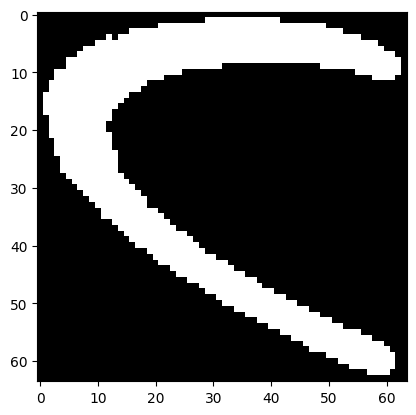

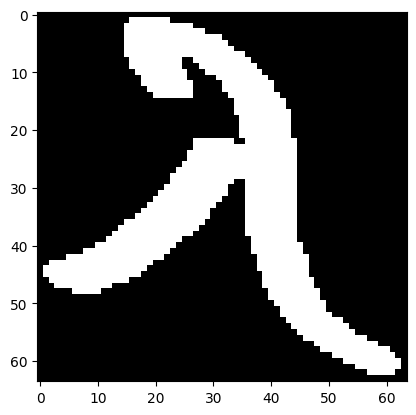

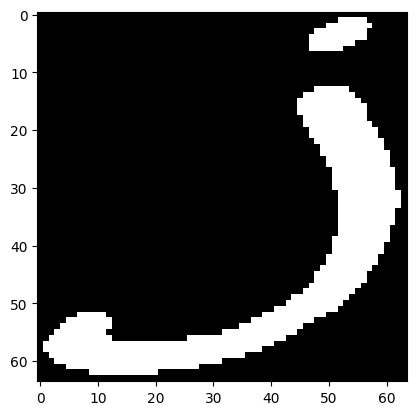

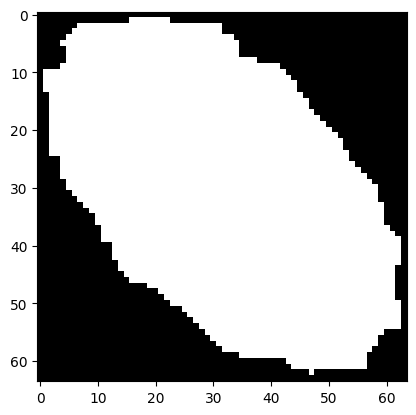

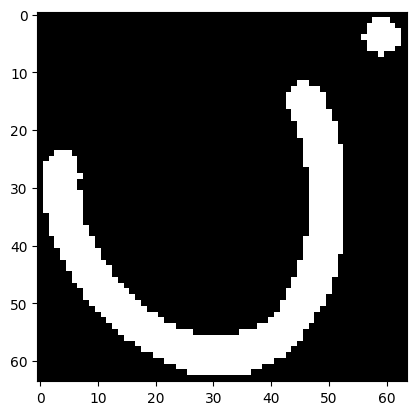

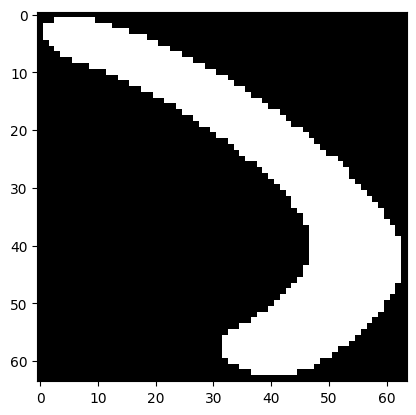

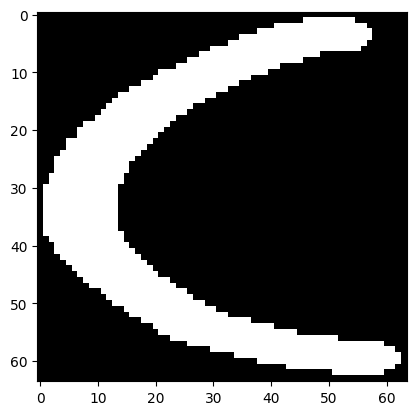

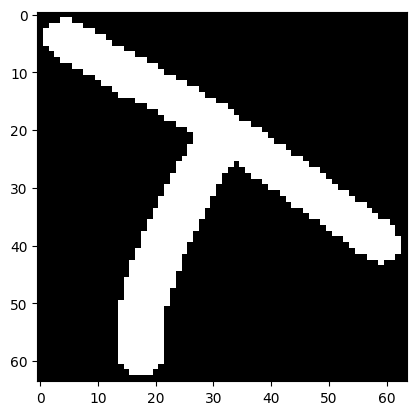

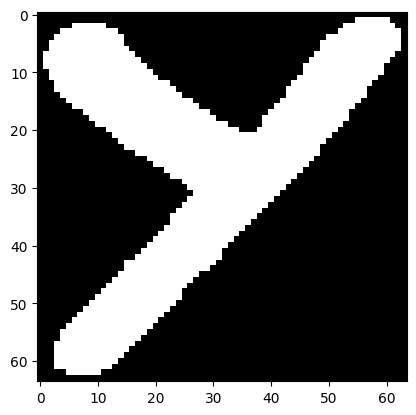

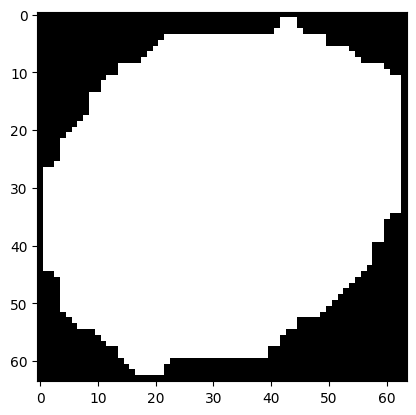

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [25]:
for im, lab in train_char_dataset:
    
    for letter in im:
    
        plt.imshow(
            rearrange(letter, "1 h w -> h w")*255, 
            cmap="gray"
        )
        plt.show()
    
    print(lab)
    break

# Load DataLoader

In [26]:
def collate_fn(batch):
    """
    Collate function to pad sequences to the same length.
    """
    # Separate images and labels
    images, labels = zip(*batch)

    # Pad image sequences
    images_padded = pad_sequence(images, batch_first=True, padding_value=0.0)

    # Pad label sequences
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0.0)

    return images_padded, labels_padded

train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=4,
    collate_fn=collate_fn
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=4,
    collate_fn=collate_fn
)

In [27]:
sorted(class_counts.keys()), len(sorted(class_counts.keys()))

(['(',
  ')',
  '+',
  '-',
  '.',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  ':',
  '<',
  '=',
  '>',
  '[',
  ']',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  '{',
  '}',
  '×',
  '÷',
  'λ'],
 52)

# Prepare Pretrained CNN Encoder

In [28]:



cnn_model: nn.Module = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 256), 
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": LOAD_CHECKPOINT,
    }
)

cnn_rnn_model: nn.Module = CNNRNNModel(
    cnn_model,
    rnn_type="rnn",
    rnn_num_layers = 4,
    num_classes=len(all_label_classes)
)

for param_name, param in cnn_rnn_model.named_parameters():
    if "rnn" in param_name:
        param.requires_grad = True
        print(f"[UNFREEZE] {param_name}")
        continue
    if "fc" in param_name:
        param.requires_grad = True
        print(f"[UNFREEZE] {param_name}")
        continue
    print(f"[FREEZE]   {param_name}")

    param.requires_grad = False
    
summary(cnn_rnn_model, (1, 2, 1, 64, 64))


Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 256]                  --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 32, 32, 32]           4,640
│    │  

Layer (type:depth-idx)                   Output Shape              Param #
CNNRNNModel                              [1, 2, 52]                --
├─AllCNN2D: 1-1                          --                        24,896
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [2, 16, 32, 32]           (2,544)
│    │    └─Sequential: 3-2              [2, 32, 16, 16]           (14,016)
│    │    └─Sequential: 3-3              [2, 32, 8, 8]             (18,624)
│    │    └─Sequential: 3-4              [2, 32, 4, 4]             (18,624)
│    │    └─Sequential: 3-5              [2, 32, 2, 2]             (18,624)
│    └─Sequential: 2-2                   [2, 128]                  --
│    │    └─Flatten: 3-6                 [2, 128]                  --
├─RNN: 1-2                               [1, 2, 128]               132,096
├─Linear: 1-3                            [1, 2, 52]                6,708
Total params: 236,132
Trainable params: 138,

# Create RNNCNN

# Create Optimiser

In [29]:
optim_parameters = {
    "lr": 0.0007224,
    "weight_decay": 0.000001
}


optim: AdamW = AdamW(cnn_rnn_model.parameters(), **optim_parameters)

scheduler: torch.optim.lr_scheduler.LRScheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=5,
    T_mult=2
)

# Train

In [30]:
DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
import torch
import torch.nn.functional as F
import tqdm
import os
import csv
from datetime import datetime
from IPython.display import clear_output



In [ ]:

# Setup
SESSION_STARTTIME_STR = datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_NAME = "cnn_rnn_model"
CSV_LOG_FILE = f"{SESSION_STARTTIME_STR}__{MODEL_NAME}__training_metric.csv"

# Write CSV header if file doesn't exist
if not os.path.isfile(CSV_LOG_FILE):
    with open(CSV_LOG_FILE, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            "epoch",
            "train_loss", "train_acc",
            "val_loss", "val_acc"
        ])

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    cnn_rnn_model.train()
    train_loss_total = 0.0
    train_correct = 0
    train_samples = 0

    train_loader = tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch + 1} - Training", leave=False)
    for X, y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        
        y_pred = cnn_rnn_model(X)

        # Convert the one-hot target labels into class indices
        y_flat = y.argmax(dim=-1)  # Shape: (batch_size, seq_len)

        # Flatten the model output and the target labels
        batch_size, seq_len, num_classes = y_pred.size()

        # Flatten y_pred to (batch_size * seq_len, num_classes)
        y_pred_flat = y_pred.view(-1, num_classes)  # Shape: (batch_size * seq_len, num_classes)

        # Flatten the target to (batch_size * seq_len)
        y_flat = y_flat.view(-1)  # Shape: (batch_size * seq_len)

        # Compute the loss (directly using logits, no softmax)
        loss = F.cross_entropy(y_pred_flat, y_flat, reduction='mean')

        optim.zero_grad()
        loss.backward()
        optim.step()

        # Track statistics
        train_loss_total += loss.item() * X.size(0)
        preds = y_pred.argmax(dim=-1).view(-1)  # Get predicted class index
        train_correct += (preds == y_flat).sum().item()  # Compare with true labels
        train_samples += X.size(0) * X.size(1)

        # Update scheduler with cosine annealing warm restarts
        scheduler.step(epoch + train_samples / len(train_dataloader.dataset))

        clear_output()
            
        # Update tqdm bar
        train_loader.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{(train_correct / train_samples):.4f}%"
        })

    # Validation
    cnn_rnn_model.eval()
    val_loss_total = 0.0
    val_correct = 0
    val_samples = 0

    val_loader = tqdm.tqdm(val_dataloader, desc=f"Epoch {epoch + 1} - Validation", leave=False)
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(DEVICE)
            y_val = y_val.to(DEVICE)
            
            y_val_pred = cnn_rnn_model(X_val)

            # Convert the one-hot target labels into class indices for validation
            y_val_flat = y_val.argmax(dim=-1)  # Shape: (batch_size, seq_len)

            # Flatten the model output and the target labels
            batch_size, seq_len, num_classes = y_val_pred.size()

            # Flatten y_val_pred to (batch_size * seq_len, num_classes)
            y_val_pred_flat = y_val_pred.view(-1, num_classes)  # Shape: (batch_size * seq_len, num_classes)

            # Flatten the target to (batch_size * seq_len)
            y_val_flat = y_val_flat.view(-1)  # Shape: (batch_size * seq_len)

            val_loss = F.cross_entropy(y_val_pred_flat, y_val_flat, reduction='mean')

            val_loss_total += val_loss.item() * X_val.size(0)
            val_preds = y_val_pred.argmax(dim=-1).view(-1)
            val_correct += (val_preds == y_val_flat).sum().item()
            val_samples += X_val.size(0) * X_val.size(1)

            
            
            clear_output()
            
            # Update tqdm bar for validation
            val_loader.set_postfix({
                "Loss": f"{val_loss.item():.4f}",
                "Acc": f"{(val_correct / val_samples):.4f}%"
            })

    # Averages
    train_loss_avg = train_loss_total / train_samples if train_samples > 0 else -1
    train_acc = train_correct / train_samples if train_samples > 0 else -1

    val_loss_avg = val_loss_total / val_samples if val_samples > 0 else -1
    val_acc = val_correct / val_samples if val_samples > 0 else -1

    # Save metrics to CSV
    with open(CSV_LOG_FILE, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch + 1,
            train_loss_avg, train_acc,
            val_loss_avg, val_acc
        ])

    # Save model
    model_filename = (
        f"{SESSION_STARTTIME_STR}__{MODEL_NAME}__"
        f"Epoch{epoch + 1}_"
        f"tLoss{train_loss_avg:.5f}_tAcc{train_acc:.5f}_"
        f"vLoss{val_loss_avg:.5f}_vAcc{val_acc:.5f}.pt"
    )
    try:
        print("Saving model")
        torch.save(cnn_rnn_model.state_dict(), model_filename)
        print(model_filename)
    except Exception as e:
        print(f"Error saving model: {e}")


Epoch 3 - Training:  78%|███████▊  | 5700/7308 [5:39:46<1:41:15,  3.78s/it, Loss=1.9366, Acc=0.5360%]

# Inference

In [ ]:
cnn_model: AllCNN2D = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.0,#0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\models\allcnn\Indigo_epoch26_trainacc0.71327_valacc0.99057_Tloss0.072851_Vloss0.0056362_lr0.0007224999999999999.pkl"
    }
)

Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 44]                   --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 32, 32, 32]           4,640
│    │  

Layer (type:depth-idx)                   Param #
AllCNN2D                                 --
├─ModuleList: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  160
│    │    └─Dropout2d: 3-2               --
│    │    └─BatchNorm2d: 3-3             32
│    │    └─LeakyReLU: 3-4               --
│    │    └─Conv2d: 3-5                  2,320
│    │    └─Dropout2d: 3-6               --
│    │    └─BatchNorm2d: 3-7             32
│    │    └─LeakyReLU: 3-8               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-9                  4,640
│    │    └─Dropout2d: 3-10              --
│    │    └─BatchNorm2d: 3-11            64
│    │    └─LeakyReLU: 3-12              --
│    │    └─Conv2d: 3-13                 9,248
│    │    └─Dropout2d: 3-14              --
│    │    └─BatchNorm2d: 3-15            64
│    │    └─LeakyReLU: 3-16              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2

In [ ]:
rnncnn_model = CNNRNNModel(
    cnn_encoder=
)

In [ ]:
for char, label in val_char_dataset:
    plt.imshow(char[0, :, :])
    plt.show()
    pred: torch.Tensor = model.forward(char.unsqueeze(0)).squeeze()
    pred_index: int = torch.argmax(pred).item()
    print(chr(int(all_label_classes[pred_index][1:], base=16)))

TypeError: pad() got an unexpected keyword argument 'mode'